# Predicting the Severity of Service Disruptions on the Telstra Network

[Telstra](https://en.wikipedia.org/wiki/Telstra) is Australia's largest telecommunications provider. In a [Kaggle challenge](https://www.kaggle.com/c/telstra-recruiting-network), the company provides a dataset of service disruptions, the severity of which is rated on a scale from 0 to 2 (2 being most severe). In addition to the severity of a disruption, a number of features from service logs is provided in different files.

In this notebook, I will consolidate the data from the different files and build a simple model to predict the severity of service disruptions.

__[1. Loading Data](#1)__<br>
<br>
__[2. Preparing Features](#2)__<br>
[2.1. severity_type](#2.1)<br>
[2.2. resource_type](#2.2)<br>
[2.3. log_feature](#2.3)<br>
[2.4. event_type](#2.4)<br>
<br>
__[3. Preparing Training and Test Sets](#3)__<br>
[3.1. Training Set](#3.1)<br>
[3.2. Test Set](#3.2)<br>
[3.3. Merging Training/Test and Feature Dataframes](#3.3)<br>
<br>
__[4. Classification Model](#4)__<br>
[4.1. Training the Model](#4.1)<br>
[4.2. Making Predictions for the Test Set](#4.2)<br>
[4.3. Attempts to Improve the Model](#4.3)<br>
[4.3.1. Add Features by Correlation with Target](#4.3.1)<br>
[4.3.2. Recursive Feature Elimination (RFE)](#4.3.2)<br>
[4.3.3. Principal Component Analysis](#4.3.3)<br>
[4.3.4. PCA with Polynomial Features](#4.3.4)

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import csv
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# 1. Loading Data<a id='1'></a>

The data are spread out over multiple files which share a common index. There are 4 files containing features (`severity_type.csv`, `resource_type.csv`, `log_feature.csv`, `event_type.csv`) in addition to two files containing the target variable (`fault_severity`) and another feature (`location`), split into training and test sets.

I will first load the training set (`train.csv`) and the 4 features into separate `DataFrame`s. Two of the file contain an incomplete third column which is the value 1 for a number of entries at the end of the file. This incomplete column will not be included as it is likely not a real feature.

In [3]:
# Load the different files into different dataframes
df = pd.read_csv('train.csv')
severity_type = pd.read_csv('severity_type.csv')
resource_type = pd.read_csv('resource_type.csv', usecols=[0,1])
log_feature = pd.read_csv('log_feature.csv')
event_type = pd.read_csv('event_type.csv', usecols=[0,1])

# 2. Preparing Features<a id='2'></a>

In the following, I will examine and transform each dataframe by checking the data types, whether the index is unique, extracting numerical features from string features, using one-hot encoding where appropriate, and checking for outliers and missing values.

## 2.1. severity_type<a id='2.1'></a>

In [4]:
severity_type.head()

,id,severity_type
0,6597,severity_type 2
1,8011,severity_type 2
2,2597,severity_type 2
3,5022,severity_type 1
4,6852,severity_type 1


In [5]:
severity_type.dtypes

id                int64
severity_type    object
dtype: object

This dataframe only contains one feature which is a string including the word "severity_type" and a number.

In [6]:
print('Number of distinct IDs: ', len(severity_type['id'].unique()))
print('Entries               : ', len(severity_type['id']))

Number of distinct IDs:  18552
Entries               :  18552


Each ID in this dataframe is assigned only one value for the feature `severity_type`.

In [7]:
# Check for missing values
severity_type.isnull().sum()

id               0
severity_type    0
dtype: int64

There are no missing values in this dataframe.

In the following, I'm defining a function that converts a string feature containing a fixed string and a number into a numerical feature.

In [8]:
def string_feature_to_numeric(df, col, fix_str):
    '''
    Checks that the column of a feature contains only integer numbers
    in addition to a fixed string, then converts the feature to a 
    numerical one, removing the string.
    df: DataFrame to operate on
    col: Column of df to convert
    fix_str: string preceding integer numbers in each sample
    '''
    
    # Check that everything that follows the string is an integer number
    # num_faults is the number of samples that do NOT contain integer
    num_faults = \
     (df[col].str.replace(fix_str,'').apply(str.isdigit) == False).sum()
    
    # Convert feature from string to integer
    if num_faults == 0:
        df[col] = df[col].str.replace(fix_str,'').astype(int)
    else:
        print('Could not convert feature to integer.')

Using the above function, I'm converting the `severity_type` feature to an integer format.

In [9]:
string_feature_to_numeric(severity_type, 'severity_type', 'severity_type ')

In [10]:
severity_type.head()

,id,severity_type
0,6597,2
1,8011,2
2,2597,2
3,5022,1
4,6852,1


In [11]:
severity_type['severity_type'].unique()

array([2, 1, 4, 5, 3])

The severity type is categorized into five different categories, but it was explicitly mentioned in the description of the data that there is no ordering to these five categories. The following histogram shows that types 1 and 2 are far more common than the rest.

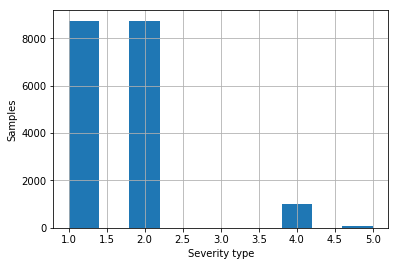

In [12]:
severity_type['severity_type'].hist()
plt.xlabel('Severity type')
plt.ylabel('Samples')
plt.show()

Since it was mentioned specifically that this feature is not ordinal, I'm going to use one-hot encoding to create five binary features for each of the categories.

In [13]:
# one-hot encoding for severity_type
tmp = pd.get_dummies(severity_type['severity_type'])
tmp.columns = np.add(['ST' for x in range(5)], tmp.columns.astype(str))

# Merge new features with index, drop old feature
severity_type = pd.concat([severity_type, tmp], axis=1)\
                .drop('severity_type', axis=1)

In [14]:
severity_type.head()

,id,ST1,ST2,ST3,ST4,ST5
0,6597,0,1,0,0,0
1,8011,0,1,0,0,0
2,2597,0,1,0,0,0
3,5022,1,0,0,0,0
4,6852,1,0,0,0,0


## 2.2. resource_type<a id='2.2'></a>

In [15]:
resource_type.head()

,id,resource_type
0,6597,resource_type 8
1,8011,resource_type 8
2,2597,resource_type 8
3,5022,resource_type 8
4,6852,resource_type 8


In [16]:
resource_type.dtypes

id                int64
resource_type    object
dtype: object

Again, the dataframe only contains one feature and it is in the form of a fixed string followed by a number.

In [17]:
print('Number of distinct IDs: ', len(resource_type['id'].unique()))
print('Entries               : ', len(resource_type['id']))

Number of distinct IDs:  18552
Entries               :  22877


In [18]:
# Checking for missing values
resource_type.isnull().sum()

id               0
resource_type    0
dtype: int64

There are no missing values.

In [19]:
# There are some IDs with more than 5 resources
(resource_type.groupby('id').count() > 5).sum()

resource_type    30
dtype: int64

In this case, the index is not unique. Rather, some indices are assigned multiple values for `resource_type`.

In [20]:
# Convert string feature to numerical
string_feature_to_numeric(resource_type, 'resource_type', 'resource_type ')

In [21]:
np.sort(resource_type['resource_type'].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

The resources are categorized into 10 different categories. From the following histogram we can tell that two of them (2 and 8) are more common than others.

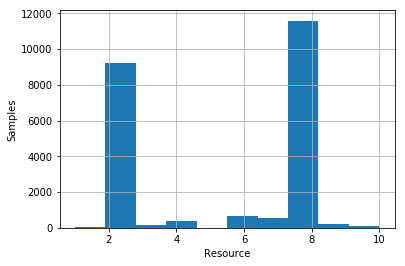

In [22]:
resource_type['resource_type'].hist()
plt.xlabel('Resource')
plt.ylabel('Samples')
plt.show()

Since it can be assumed that the categories are not ordinal in nature, I'm going to encode them with one-hot encoding.

In [23]:
#One-hot encoding of resource_type
tmp = pd.get_dummies(resource_type['resource_type'])

# Name the columns RTx where x is the category
tmp.columns = np.add(['RT' for x in range(10)], tmp.columns.astype(str))

# Merge resource_type with new features, drop original feature
resource_type = pd.concat([resource_type, tmp], axis=1)\
                .drop('resource_type', axis=1)

In [24]:
resource_type.head()

,id,RT1,RT2,RT3,RT4,RT5,RT6,RT7,RT8,RT9,RT10
0,6597,0,0,0,0,0,0,0,1,0,0
1,8011,0,0,0,0,0,0,0,1,0,0
2,2597,0,0,0,0,0,0,0,1,0,0
3,5022,0,0,0,0,0,0,0,1,0,0
4,6852,0,0,0,0,0,0,0,1,0,0


Since I noted that the index isn't unique, i.e. that there are multiple instances of one index with different categories, I'm grouping the entries by index and summing up the entries for each category.

In [25]:
resource_type = resource_type.groupby('id', as_index=False).sum()

## 2.3. log_feature<a id='2.3'></a>

In [26]:
log_feature.head()

,id,log_feature,volume
0,6597,feature 68,6
1,8011,feature 68,7
2,2597,feature 68,1
3,5022,feature 172,2
4,5022,feature 56,1


In [27]:
log_feature.dtypes

id              int64
log_feature    object
volume          int64
dtype: object

In [28]:
print('Number of distinct IDs: ', len(log_feature['id'].unique()))
print('Entries               : ', len(log_feature['id']))

Number of distinct IDs:  18552
Entries               :  58671


This dataframe contains two features, `log_feature` and `volume`. The former is again a string features containing the numerical value after a fixed expression. The index is not unique in this dataframe either. Instead, a single ID can correspond to several log features.

In [29]:
# No missing values
log_feature.isnull().sum()

id             0
log_feature    0
volume         0
dtype: int64

There are no missing data in this dataframe.

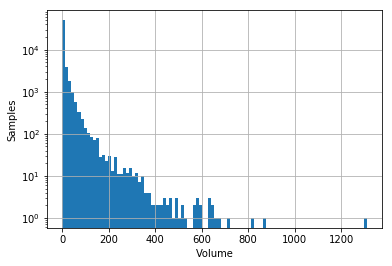

In [30]:
log_feature['volume'].hist(bins=100, log=True)
plt.xlabel('Volume')
plt.ylabel('Samples')
plt.show()

The distribution for `volume` shows that there are no extreme outliers.

Next, I'm converting the log feature from string to a numerical value:

In [31]:
string_feature_to_numeric(log_feature, 'log_feature', 'feature ')

The following two graphics show the distribution of log features. Some of them are much more common than others, but there are no extreme outliers.

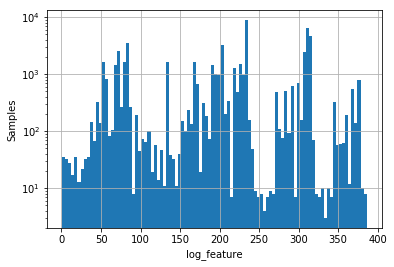

In [32]:
log_feature['log_feature'].hist(bins=100, log=True)
plt.xlabel('log_feature')
plt.ylabel('Samples')
plt.show()

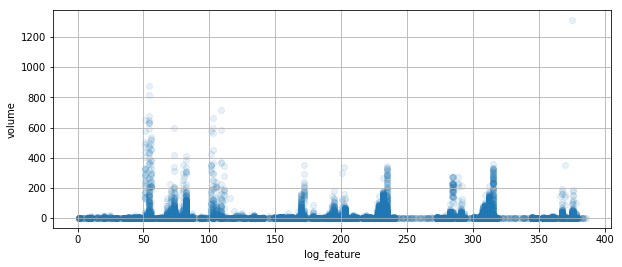

In [33]:
plt.figure(figsize=(10,4))
plt.scatter(log_feature['log_feature'], log_feature['volume'], alpha=0.1)
plt.xlabel('log_feature')
plt.ylabel('volume')
plt.grid()
plt.show()

Since the log features are not ordinal, I'm re-encoding them in individual features, which contain the volume value.

In [34]:
# create new column for each feature and fill it with volume value
tmp = pd.get_dummies(log_feature['log_feature'])

# the column names are LFx, where x stands for the log feature
tmp.columns = np.add(['LF' for x in range(386)], tmp.columns.astype(str))

# Fill the columns with the corresponding volume number
for col in tmp.columns:
    tmp[col] *= log_feature['volume']

# Merge new features with index and drop old log feature and volume cols
log_feature = pd.concat([log_feature, tmp], axis=1)\
              .drop(['log_feature','volume'], axis=1)

In [35]:
log_feature.loc[:5,['id','LF170','LF171','LF172','LF173','LF174']]

,id,LF170,LF171,LF172,LF173,LF174
0,6597,0,0,0,0,0
1,8011,0,0,0,0,0
2,2597,0,0,0,0,0
3,5022,0,0,2,0,0
4,5022,0,0,0,0,0
5,5022,0,0,0,0,0


Finally, the data are grouped by index and summed up.

In [36]:
log_feature = log_feature.groupby('id', as_index=False).sum()

## 2.4. event_type<a id='2.4'></a>

In [37]:
event_type.head()

,id,event_type
0,6597,event_type 11
1,8011,event_type 15
2,2597,event_type 15
3,5022,event_type 15
4,5022,event_type 11


In [38]:
event_type.dtypes

id            object
event_type    object
dtype: object

In this dataframe, the index is not an integer but a string. Before converting it to an integer, I'm checking that every entry is indeed an integer.

In [39]:
# Check that all entries in 'id' are actually int numbers
(event_type['id'].apply(str.isdigit) == False).sum()

1

Actually, I sample contains a non-numeric ID value and I'm going to remove this sample in the following:

In [40]:
# There is one entry in 'id' that is not a value number
event_type[event_type['id'].apply(str.isdigit)==False]

,id,event_type
31170,_type 50,1


In [41]:
# Remove the one sample with an invald 'id'
event_type = event_type[event_type['id'].apply(str.isdigit)==True]

# Convert 'id' to int
event_type['id'] = event_type['id'].astype(int)

In [42]:
print('Number of distinct IDs: ', len(event_type['id'].unique()))
print('Events                : ', len(event_type['id']))

Number of distinct IDs:  18552
Events                :  34082


Again, there are IDs that are associated with multiple event types, so I'll group the entries by ID at the end of this section.

In [43]:
# Checking for missing values
event_type.isnull().sum()

id            0
event_type    0
dtype: int64

There are no missing values in the dataframe. Next, I'm converting the `event_type` feature from string to numeric:

In [44]:
string_feature_to_numeric(event_type, 'event_type', 'event_type ')

In [45]:
np.sort(event_type['event_type'].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54])

There are 52 distinct event types. The following histogram shows that some are much more frequent than others, but there are no extreme outliers.

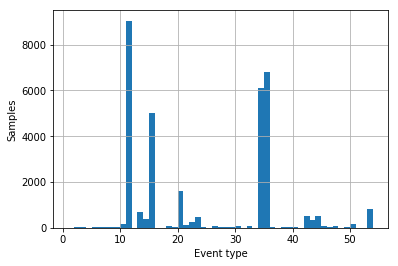

In [46]:
event_type['event_type'].hist(bins=53)
plt.xlabel('Event type')
plt.ylabel('Samples')
plt.show()

As the events are not ordinal, I'm re-encoding them with a separate feature for each event.

In [47]:
# One-hot encoding: create new feature for each of the 53 columns
tmp = pd.get_dummies(event_type['event_type'])

# Rename columnsas ETx where x stands for an event type
tmp.columns = np.add(['ET' for x in range(53)], tmp.columns.astype(str))

# Merge one-hot encoded features with index, remove old feature
event_type = pd.concat([event_type, tmp], axis=1)\
             .drop('event_type', axis=1)

In [48]:
event_type.head()

,id,ET1,ET2,ET3,ET4,ET5,ET6,ET7,ET8,ET9,...,ET45,ET46,ET47,ET48,ET49,ET50,ET51,ET52,ET53,ET54
0,6597,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8011,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2597,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5022,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5022,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now I'm going to group the data by ID and sum up the instances for each event type.

In [49]:
event_type = event_type.groupby('id', as_index=False).sum()

# 3. Preparing Training and Test Sets<a id='3'></a>

## 3.1. Training Set<a id='3.1'></a>

In [50]:
df.head()

,id,location,fault_severity
0,14121,location 118,1
1,9320,location 91,0
2,14394,location 152,1
3,8218,location 931,1
4,14804,location 120,0


In [51]:
df.dtypes

id                 int64
location          object
fault_severity     int64
dtype: object

In [52]:
print('Number of distinct IDs: ', len(df['id'].unique()))
print('Entries               : ', len(df['id']))

Number of distinct IDs:  7381
Entries               :  7381


In [53]:
# Checking for missing values
df.isnull().sum()

id                0
location          0
fault_severity    0
dtype: int64

The training data don't contain missing data, the index is unique, and the location is given as a string features, which needs to be converted to an integer:

In [54]:
string_feature_to_numeric(df, 'location', 'location ')

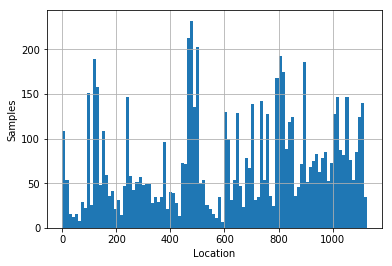

In [55]:
df['location'].hist(bins=100)
plt.xlabel('Location')
plt.ylabel('Samples')
plt.show()

The location distribution doesn't show extreme outliers.

In [56]:
df['fault_severity'].unique()

array([1, 0, 2])

All instances of the target variable `fault_severity` are indeed 0, 1, or 2.

## 3.2. Test Set<a id='3.2'></a>

In [57]:
df_test = pd.read_csv('test.csv')

In [58]:
df_test.head()

,id,location
0,11066,location 481
1,18000,location 962
2,16964,location 491
3,4795,location 532
4,3392,location 600


In [59]:
df_test.dtypes

id           int64
location    object
dtype: object

In [60]:
print('Number of distinct IDs: ', len(df_test['id'].unique()))
print('Entries               : ', len(df_test['id']))

Number of distinct IDs:  11171
Entries               :  11171


In [61]:
# Check for missing values
df_test.isnull().sum()

id          0
location    0
dtype: int64

The test set has the same format as the trainig set (of course missing the target variable `fault_severity`. There are no missing values, and the location feature needs to be converted from a string to a numeric feature:

In [62]:
string_feature_to_numeric(df_test, 'location', 'location ')

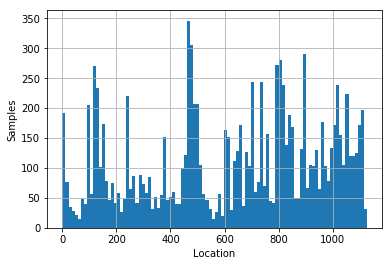

In [63]:
df_test['location'].hist(bins=100)
plt.xlabel('Location')
plt.ylabel('Samples')
plt.show()

The distribution of locations doesn't show any outliers.

## 3.3. Merging Training/Test and Feature Dataframes<a id='3.3'></a>

Having prepared the various features on one hand, and the training/test datasets on the other hand, I'm now merging the training and test sets with the features.

In [64]:
# Merge training set with features
df_train = pd.merge(df, severity_type, on='id', how='left')
df_train = pd.merge(df_train, resource_type, on='id', how='left')
df_train = pd.merge(df_train, log_feature, on='id', how='left')
df_train = pd.merge(df_train, event_type, on='id', how='left')
df_train.head()

,id,location,fault_severity,ST1,ST2,ST3,ST4,ST5,RT1,RT2,...,ET45,ET46,ET47,ET48,ET49,ET50,ET51,ET52,ET53,ET54
0,14121,118,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,9320,91,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,14394,152,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,8218,931,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,14804,120,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [65]:
# Merge test data with features
df_test = pd.merge(df_test, severity_type, on='id', how='left')
df_test = pd.merge(df_test, resource_type, on='id', how='left')
df_test = pd.merge(df_test, log_feature, on='id', how='left')
df_test = pd.merge(df_test, event_type, on='id', how='left')
df_test.head()

,id,location,ST1,ST2,ST3,ST4,ST5,RT1,RT2,RT3,...,ET45,ET46,ET47,ET48,ET49,ET50,ET51,ET52,ET53,ET54
0,11066,481,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,18000,962,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16964,491,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4795,532,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,3392,600,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 4. Classification Model<a id='4'></a>

## 4.1. Training the Model<a id='4.1'></a>

First, I'm splitting the data into a feature matrix `X` and a target column `y`.

In [66]:
X_train = df_train.drop(['fault_severity'], axis=1)
y_train = df_train['fault_severity']

The problem is a single-label, multi-class classification problem. The target has three different classes (0,1,2). As the following graphic shows, there is considerable class imbalance which means that accuracy is likely not a good metric to evaluate the model because it will favor models that tend to predict the predominant class. Instead, I will use the F1 score (the harmonic mean of precision and recall) to evaluate my model.

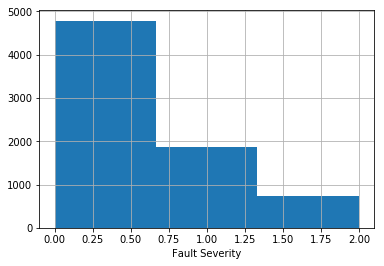

In [67]:
df_train['fault_severity'].hist(bins=3)
plt.xlabel('Fault Severity')
plt.show()

I'm using four different classifiers implemented in `scikit-learn` to model that data. For each one, I'm using 5-fold cross validation on the training set to determine the F1 score.

In [68]:
classifiers = [KNeighborsClassifier(),
               RandomForestClassifier(),
               GaussianNB(),
               LogisticRegression()
              ]
classifier_names = ['kNN','forest','GNB','LogReg']

In [69]:
# Loop through classifiers
for classifier, clf_name in zip(classifiers, classifier_names): 
    
    # Calculate CV
    print(clf_name,'\t',cross_val_score(estimator=classifier, 
            X=X_train, y=y_train, cv=5, scoring='f1_macro').mean())

kNN 	 0.3500089692526277
forest 	 0.6453935093915613
GNB 	 0.37428942083539385
LogReg 	 0.4965441321576131


The random forest classifier performs best with an F1 score of 0.65.

## 4.2. Making Predictions for the Test Set<a id='4.2'></a>

Having found a model with a reasonable score, I'm now going to make and export the predictions for the test set.

The dataframe `df_test` is actually the complete feature matrix:

In [70]:
X_test = df_test

First, the random forest classifier is trained on the training set, then it is used to predict the fault severity for the test set.

In [71]:
forest = RandomForestClassifier()
forest.fit(X_train,y_train)  # Fit classifier on training set
y_pred = forest.predict(X_test) # Predict fault severity on test set

In [72]:
y_pred.shape

(11171,)

The Kaggle competition asked for a specific format for submission files, having a separate column for each fault severity. The following code converts the predictions in `y_pred` to the specified format.

In [73]:
results = pd.get_dummies(y_pred)     # create separate columns
results.columns = ['predict_0', 'predict_1', 'predict_2']  #rename cols
results = pd.concat([df_test[['id']], results], axis=1) # merge with index
results = results.set_index('id')  # set ID as index
results.head()

,predict_0,predict_1,predict_2
id,,,
11066,1,0,0
18000,0,0,1
16964,1,0,0
4795,1,0,0
3392,0,1,0


Finally, the predictions are exported into a csv file.

In [74]:
results.to_csv('submission.csv')

## 4.3. Attempts to Improve the Model<a id='4.3'></a>

In the following, I'll try four different feature selection techniques to improve the model. Using the second approach, RFE, the F1 score improves marginally to 0.66 but using only about a quarter of the features.

(1) First, I will select features based on their correlation with the target variable. (2) Then, I'll try to select features through recursive feature elimination (RFE). (3) I will then try to use principal component analysis (PCA) to reduce the dimensionality of the feature matrix. (4) Finally, I will combine PCA with interaction features (adding quadratic features).

### 4.3.1. Add Features by Correlation with Target<a id='4.3.1'></a>

I'm going to be using the following function for both this attempt and the next one (RFE). It plots the scores for two classifiers (Gaussian Naive Bayes and Random Forests) for a feature set that continuously grows according to a ranking provided in `features_ranking`.

In [75]:
def plot_feature_series(features_ranking):
    '''
    Evaluates GaussianNB() and RandomForestClassifier() on a continuously 
    increasing feature set. The features are added in an order specified 
    in 'features_ranking'. The performance of both classifiers is then 
    plotted. 
    'features_ranking' (list): list of features ordered by 
                               relevance (descening)
    '''
    # Lists to store feature names and scores
    features, scores_GNB, scores_forest = [], [], []  

    # For each feature in descening order or relevance
    for i in range(len(features_ranking)): 
        
        # List of features to be evaluated
        good_cols = list(features_ranking[:i+1])
        
        # Perform 3-fold CV for both classifiers on the current 
        # list of features, evaulate F1 score
        cvs_GNB = cross_val_score(estimator=GaussianNB(), 
                            X=X_train[good_cols], y=y_train, 
                            cv=3, scoring='f1_macro').mean()
        cvs_forest = cross_val_score(estimator=RandomForestClassifier(), 
                            X=X_train[good_cols], y=y_train,
                            cv=3, scoring='f1_macro').mean()
        
        # Store name of latest feature and scores of both classifiers
        features.append(features_ranking[i])
        scores_GNB.append(cvs_GNB)
        scores_forest.append(cvs_forest)

    # Plot scores for both classifiers    
    plt.figure(figsize=(12,4))
    plt.plot(scores_GNB, label='GaussianNB')
    plt.plot(scores_forest, label='Random Forest')
    plt.xticks(range(len(features)), features, rotation=90)
    plt.xlabel('Added Feature (left to right)')
    plt.ylabel('F1 score')
    plt.legend()
    plt.grid()
    plt.show()
    
    print('Ideal no. of features (GNB): %d | Ideal no. of features (RandomForest): %d' %\
          ( scores_GNB.index(max(scores_GNB))+1 , scores_forest.index(max(scores_forest))+1 ))

I'm calculating a ranked list of features `corr_list` based on their respective correlation with the target. Then, using the above function, I'm evaluating how the two classifiers are performing on the growing feature set.

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

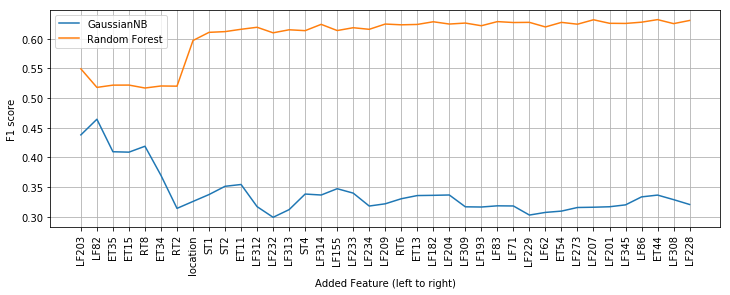

Ideal no. of features (GNB): 2 | Ideal no. of features (RandomForest): 37


In [76]:
# Calculate list of features sorted by correlation with target
corr_list = abs(df_train.corr()['fault_severity'])\
            .sort_values(ascending=False)[1:40]

plot_feature_series(corr_list.index)

Neither classifier exceeds the F1 score of 0.64 achieved with random forests on the full feature set.

### 4.3.2. Recursive Feature Elimination (RFE)<a id='4.3.2'></a>

Now, I'm going to use RFE to create a ranked list of features. I'll use the correlation with the target to pre-select a set of 100 features.

In [77]:
# List of 30 features that have the strongest correlation with the target
corr_cols = list(abs(df_train.corr()['fault_severity'])\
                 .sort_values(ascending=False)[1:100].index)

In [78]:
# Train RFE model on the training set, with logistic regression 
# as evaluating estimator
rfe = RFE(LogisticRegression(),1,step=1)
rfe.fit(X_train[corr_cols], y_train)

RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
  n_features_to_select=1, step=1, verbose=0)

The following list `rfe_list` is a list of the 100 features, sorted by rank according to the RFE algorithm.

In [79]:
rfe_list = list(pd.Series(X_train[corr_cols].columns, index=rfe.ranking_)\
                .sort_index().values)

The function `plot_feature_series` now evaluated the two classifiers for a growing feature set (according to `rfe_list`).

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

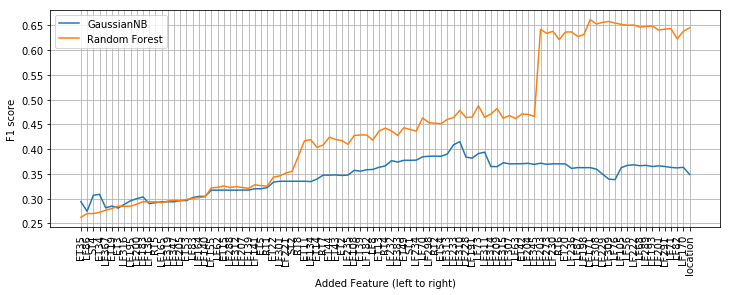

Ideal no. of features (GNB): 62 | Ideal no. of features (RandomForest): 83


In [80]:
plot_feature_series(rfe_list)

Using the first 85 features of the RFE-sorted feature list, the random forest classifiers achieves a better F1 score (0.66) than with the full set of over 400 features (0.64).

In [81]:
cross_val_score(estimator=RandomForestClassifier(), 
            X=X_train[rfe_list[:85]], y=y_train, cv=5, scoring='f1_macro').mean()

0.6553709044991198

### 4.3.3. Principal Component Analysis<a id='4.3.3'></a>

Another way to reduce the dimensionality of the feature matrix is through PCA. The following code builds a pipeline in which the features are standardized (a requirement for PCA), the PCA is performed to reduce the number of features to 200, and finally the reduced feature matrix is evaluated with random forests.

In [82]:
pipe = Pipeline([('std',StandardScaler()),
                 ('pca',PCA(n_components=200)),
                 ('forest', RandomForestClassifier())
])
cross_val_score(estimator=pipe, X=X_train, y=y_train,
                cv=5, scoring='f1_macro').mean()

0.6019685594501268

### 4.3.4. PCA with Polynomial Features<a id='4.3.4'></a>

In order to take into account interaction between features, I'm using `scikit-learn`'s `PolynomialFeatures()` function to create quadratic features. Since this increases the feature matrix dramatically, I am using PCA to reduce the feature matrix before creating interaction features.

In [83]:
pipe = Pipeline([('std',StandardScaler()),
                 ('pca',PCA(n_components=50)),
                 ('poly',PolynomialFeatures(2)),
                 ('forest', RandomForestClassifier())
])
cross_val_score(estimator=pipe, X=X_train, y=y_train,
                cv=5, scoring='f1_macro').mean()

0.5601360541669964